<h2>Analyse de Sentiments sur Twitter</h2>

Le projet d'analyse de Tweets de la base Sentiment140 vise à
utiliser des techniques d'apprentissage automatique pour classer
les tweets en fonction de leur polarité (positif, négatif ou neutre).

1 - Importation des bibliotheques utiles

In [1]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Chargement et préparation des données
def load_data(filename, nrows=100000):
    """
    Charge les données depuis le fichier CSV avec un nombre limité de lignes
    """
    columns = ['target', 'id', 'date', 'flag', 'user', 'text']
    df = pd.read_csv(filename, 
                     encoding='ISO-8859-1',
                     names=columns,
                     nrows=nrows)
    
    # Assurons-nous d'avoir un échantillon équilibré des deux classes
    n_samples_per_class = nrows // 2
    df_neg = df[df['target'] == 0].head(n_samples_per_class)
    df_pos = df[df['target'] == 4].head(n_samples_per_class)
    
    # Combinons les échantillons équilibrés
    df_balanced = pd.concat([df_neg, df_pos], axis=0)
    df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)  # Mélanger les données
    
    print(f"Distribution des classes après équilibrage:\n{df_balanced['target'].value_counts()}")
    return df_balanced

In [3]:
# 2. Prétraitement du texte
def preprocess_text(text):
    """
    Nettoie et prétraite le texte des tweets
    """
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Suppression des mentions utilisateurs
    text = re.sub(r'@\w+', '', text)
    
    # Suppression des hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Suppression des caractères spéciaux et nombres
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Suppression des stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [4]:
# 3. Analyse exploratoire des données
def explore_data(df):
    """
    Réalise une analyse exploratoire des données
    """
    # Distribution des sentiments
    plt.figure(figsize=(8, 6))
    sns.countplot(x='target', data=df)
    plt.title('Distribution des sentiments')
    plt.xlabel('Sentiment (0: Négatif, 4: Positif)')
    plt.ylabel('Nombre de tweets')
    plt.show()
    
    # Longueur moyenne des tweets par sentiment
    df['tweet_length'] = df['text'].apply(len)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='target', y='tweet_length', data=df)
    plt.title('Distribution de la longueur des tweets par sentiment')
    plt.xlabel('Sentiment (0: Négatif, 4: Positif)')
    plt.ylabel('Longueur du tweet')
    plt.show()
    
    # Affichage de quelques statistiques
    print("\nStatistiques sur la longueur des tweets:")
    print(df.groupby('target')['tweet_length'].describe())

In [5]:
# 4. Préparation des données pour l'entraînement
def prepare_data(df):
    """
    Prépare les données pour l'entraînement du modèle
    """
    # Prétraitement des tweets
    print("Prétraitement des tweets...")
    df['processed_text'] = df['text'].apply(preprocess_text)
    
    # Vectorisation du texte
    print("Vectorisation du texte...")
    vectorizer = TfidfVectorizer(max_features=5000, min_df=5)
    X = vectorizer.fit_transform(df['processed_text'])
    
    # Préparation des labels
    y = df['target'].map({0: 0, 4: 1})  # Conversion en 0 et 1
    
    # Vérification des classes
    print("\nDistribution des classes:")
    print(pd.Series(y).value_counts())
    
    return X, y, vectorizer

In [6]:
# 5. Entraînement et évaluation du modèle
def train_and_evaluate_model(X, y):
    """
    Entraîne et évalue le modèle avec GridSearchCV
    """
    # Définition des paramètres pour GridSearchCV
    params = {
        'C': [0.1, 1, 10],
        'max_iter': [1000],
        'class_weight': ['balanced']
    }
    
    # Initialisation du modèle
    model = LogisticRegression(random_state=42)
    
    # GridSearchCV
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
    grid_search.fit(X, y)
    
    print("\nMeilleurs paramètres:", grid_search.best_params_)
    print("Meilleur score CV:", grid_search.best_score_)
    
    return grid_search.best_estimator_

In [17]:
# Chargement des données d'entraînement
print("Chargement des données...")
train_df = load_data('training.1600000.processed.noemoticon.csv', nrows=1000000)

Chargement des données...
Distribution des classes après équilibrage:
target
0    500000
4    200000
Name: count, dtype: int64



Analyse exploratoire des données...


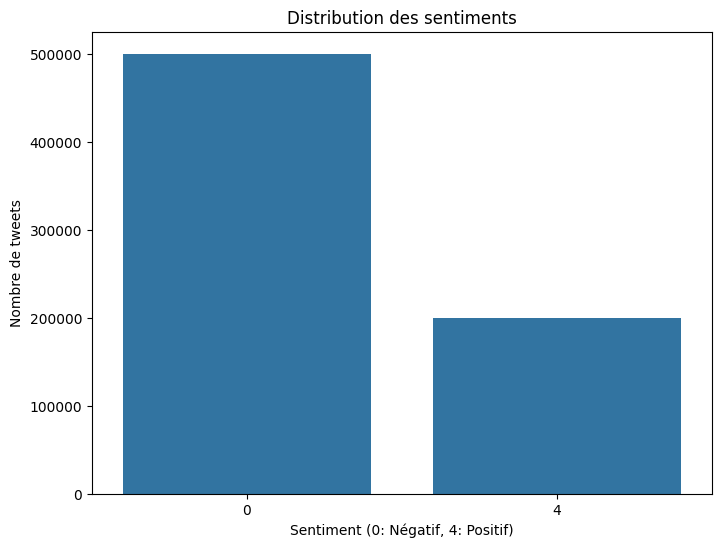

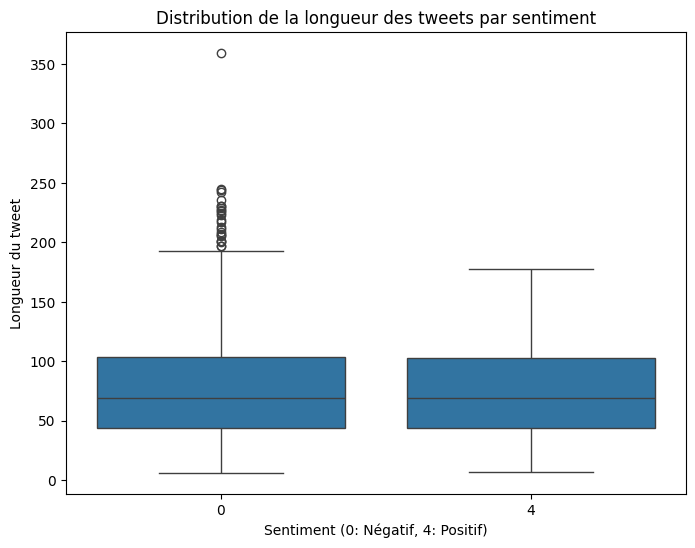


Statistiques sur la longueur des tweets:
           count       mean        std  min   25%   50%    75%    max
target                                                               
0       500000.0  74.108156  36.736459  6.0  44.0  69.0  104.0  359.0
4       200000.0  74.172550  36.111521  7.0  44.0  69.0  103.0  178.0


In [18]:
# Analyse exploratoire
print("\nAnalyse exploratoire des données...")
explore_data(train_df)

In [19]:
# Préparation des données
print("\nPréparation des données...")
X, y, vectorizer = prepare_data(train_df)


Préparation des données...
Prétraitement des tweets...
Vectorisation du texte...

Distribution des classes:
target
0    500000
1    200000
Name: count, dtype: int64


In [20]:
# Entraînement du modèle
print("\nEntraînement du modèle...")
model = train_and_evaluate_model(X, y)


Entraînement du modèle...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Meilleurs paramètres: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}
Meilleur score CV: 0.7650671428571428


In [22]:
# Chargement et préparation des données de test
print("\nChargement des données de test...")
test_df = pd.read_csv('testdata.manual.2009.06.14.csv', encoding='ISO-8859-1',
                         names=['target', 'id', 'date', 'flag', 'user', 'text'])


Chargement des données de test...


In [23]:
# Prétraitement des données de test
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
X_test = vectorizer.transform(test_df['processed_text'])
y_test = test_df['target'].map({0: 0, 2: 1, 4: 1})  # Regroupement des neutres et positifs

In [24]:
# Évaluation sur les données de test
y_pred = model.predict(X_test)
print("\nRésultats sur les données de test:")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))


Résultats sur les données de test:

Rapport de classification:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72       178
           1       0.88      0.78      0.83       338

    accuracy                           0.78       516
   macro avg       0.77      0.79      0.77       516
weighted avg       0.80      0.78      0.79       516



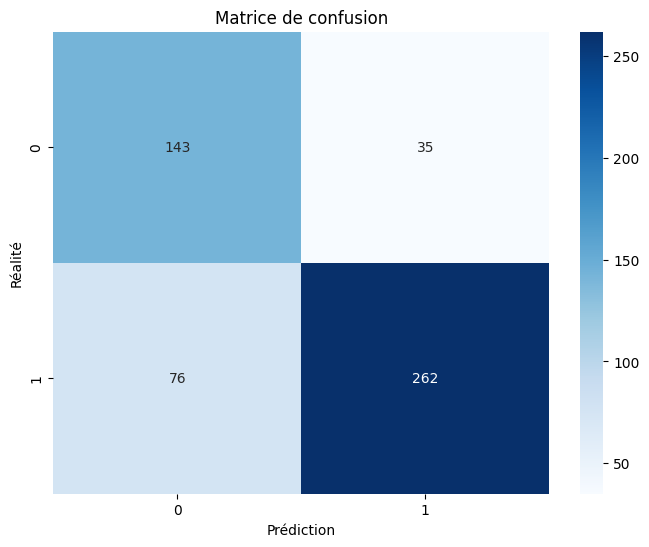

In [25]:
# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()